In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

import gensim
from gensim import corpora
from gensim.similarities import SparseTermSimilarityMatrix
from gensim.similarities import SoftCosineSimilarity

BATCH_SIZE = 32
EPOCHS = 5
MAX_LEN = 75
EMBEDDING = 20

Using TensorFlow backend.


# 練習用資料處理

In [125]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")
print("Number of sentences: ", len(data.groupby(['Sentence #'])))
words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)
tags = list(set(data["Tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)
print("What the dataset looks like:")
# Show the first 10 rows
data.head(n=10)

Number of sentences:  47959
Number of words in the dataset:  35178
Tags: ['I-eve', 'I-art', 'I-org', 'I-geo', 'O', 'B-art', 'B-tim', 'B-gpe', 'B-org', 'I-per', 'B-per', 'B-nat', 'B-eve', 'I-nat', 'B-geo', 'I-tim', 'I-gpe']
Number of Labels:  17
What the dataset looks like:


Sentence #           Word  POS    Tag
0  Sentence: 1      Thousands  NNS      O
1  Sentence: 1             of   IN      O
2  Sentence: 1  demonstrators  NNS      O
3  Sentence: 1           have  VBP      O
4  Sentence: 1        marched  VBN      O
5  Sentence: 1        through   IN      O
6  Sentence: 1         London  NNP  B-geo
7  Sentence: 1             to   TO      O
8  Sentence: 1        protest   VB      O
9  Sentence: 1            the   DT      O

In [126]:
class SentenceGetter(object):
    """Class to Get the sentence in this format:
    [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_1, Tag_1)]"""
    def __init__(self, data):
        """Args:
            data is the pandas.DataFrame which contains the above dataset"""
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        """Return one sentence"""
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)
sent = getter.get_next()
print('This is what a sentence looks like:')
print(sent)

This is what a sentence looks like:
[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [127]:
sentences = getter.sentences

In [130]:
# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding
# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}
# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}
print("The word Obama is identified by the index: {}".format(word2idx["Obama"]))
print("The labels B-geo(which defines Geopraphical Enitities) is identified by the index: {}".format(tag2idx["B-geo"]))

from keras.preprocessing.sequence import pad_sequences
# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])
# Convert Tag/Label to tag_index
y = [[tag2idx[w[2]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])

from keras.utils import to_categorical
# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.9)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape
print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
print('Raw Label: ', ' '.join([w[2] for w in sentences[0]]))
print('After processing, sample:', X[0])
print('After processing, labels:', y[0])

The word Obama is identified by the index: 2593
The labels B-geo(which defines Geopraphical Enitities) is identified by the index: 15
Raw Sample:  Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
Raw Label:  O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O
After processing, sample: [29166  7752 23491 33353 24149  6131 28083  3487 12341 31260  7283 14684
  1677  6217 26321 31260 19019  7752  9949  9494 34583 16282  3314 14257
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
After processing, labels: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0.

In [132]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.99)
len(X_tr)

479

# 實際數據

In [158]:
data['Sentence'][4]

'the QNAP NAS is not booting the red status just keeps blinking. I tried with two different power supplies the same result.Them I removed all six drives and M.2 caches card the same result. I know my unit is out of warranty I need to have it fixed. Please help thank you in advance ... Jason'

In [35]:
import spacy
# nlp = spacy.load('en_core_web_sm')
data = pd.read_pickle('./data/event_train.pkl')

words_lt = []
tags_lt = []
for i in range(len(data)):
    tags_lt.extend(data.iloc[i][1])
    doc = nlp(data.iloc[i][0])
    for token in doc:
        words_lt.append(token.lower_)

words = list(set(words_lt))
n_words = len(words)
print("Number of words in the dataset: ", n_words)

tags = list(set(tags_lt))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

Number of words in the dataset:  2677
Tags: ['L-Light', 'B-Light', 'B-Act', 'U-Tri', 'I-Tri', 'I-Act', 'B-Tri', 'U-Oth', 'U-Act', 'L-Act', 'I-Oth', 'O', '-', 'U-Light', 'L-Tri', 'L-Oth', 'B-Oth']
Number of Labels:  17


In [67]:
#轉換成w2v
word2vec = gensim.models.KeyedVectors.load('./data/crawl-300d-2M')
embedding_matrix = np.zeros((n_words+1, word2vec.vector_size))
word2idx = {}

for i, word in enumerate(words):
    if word in word2vec.vocab:
        embedding_matrix[i + 1] = word2vec[word]
        word2idx[word] = i + 1
        
def text_to_index(sentences):
    new_corpus = []
    for s in sentences:
        new_doc = []
        doc = nlp(s)
        for word in doc:
            try:
                new_doc.append(word2idx[word.text])
            except:
                new_doc.append(0)
        new_corpus.append(new_doc)
    return np.array(new_corpus)

In [70]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

#w2v當字典轉id
X = text_to_index(data['Sentence'].values)
X = pad_sequences(X, maxlen=MAX_LEN)

idx2word = {i: w for w, i in word2idx.items()}

tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

y = [[tag2idx[w] for w in s] for s in data['label'].values]
# Padding each sentence to have the same lenght
y = pad_sequences(y, maxlen=MAX_LEN)

# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

C:\Users\PhilipHuang\anaconda3\lib\site-packages\ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [200]:
len(y_te)

179

In [36]:
#自身字典轉id
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

X = [[word2idx[w.lower_] for w in nlp(s)] for s in data['Sentence'].values]
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

y = [[tag2idx[w] for w in s] for s in data['label'].values]
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])

y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

In [82]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

input = Input(shape=(MAX_LEN,))

# w2v用
model = Embedding(input_dim=embedding_matrix.shape[0],
                  output_dim=embedding_matrix.shape[1],
                  weights=[embedding_matrix], # n_words + 2 (PAD & UNK)
                  input_length=MAX_LEN,
                  trainable=False)(input)  # default: 20-dim embedding

# model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
#                   input_length=MAX_LEN)(input)  # default: 20-dim embedding

model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output
model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
model.summary()

C:\Users\PhilipHuang\anaconda3\lib\site-packages\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
C:\Users\PhilipHuang\anaconda3\lib\site-packages\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 300)           803400    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           140400    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 18)            1278      
Total params: 950,128
Trainable params: 146,728
Non-trainable params: 803,400
_________________________________________________________________


In [81]:
keras.backend.clear_session()

In [180]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.01)
len(X_te)

5

In [110]:
history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE,
                    epochs=10,validation_split=0.1, verbose=2)

Train on 1440 samples, validate on 160 samples
Epoch 1/10
 - 3s - loss: 0.0622 - crf_viterbi_accuracy: 0.9797 - val_loss: 0.0676 - val_crf_viterbi_accuracy: 0.9785
Epoch 2/10
 - 3s - loss: 0.0555 - crf_viterbi_accuracy: 0.9819 - val_loss: 0.0626 - val_crf_viterbi_accuracy: 0.9809
Epoch 3/10
 - 3s - loss: 0.0492 - crf_viterbi_accuracy: 0.9843 - val_loss: 0.0555 - val_crf_viterbi_accuracy: 0.9841
Epoch 4/10
 - 3s - loss: 0.0447 - crf_viterbi_accuracy: 0.9848 - val_loss: 0.0528 - val_crf_viterbi_accuracy: 0.9836
Epoch 5/10
 - 3s - loss: 0.0416 - crf_viterbi_accuracy: 0.9853 - val_loss: 0.0492 - val_crf_viterbi_accuracy: 0.9854
Epoch 6/10
 - 3s - loss: 0.0380 - crf_viterbi_accuracy: 0.9862 - val_loss: 0.0474 - val_crf_viterbi_accuracy: 0.9848
Epoch 7/10
 - 3s - loss: 0.0352 - crf_viterbi_accuracy: 0.9863 - val_loss: 0.0449 - val_crf_viterbi_accuracy: 0.9850
Epoch 8/10
 - 3s - loss: 0.0327 - crf_viterbi_accuracy: 0.9866 - val_loss: 0.0452 - val_crf_viterbi_accuracy: 0.9848
Epoch 9/10
 - 3s 

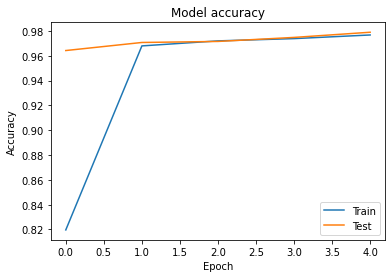

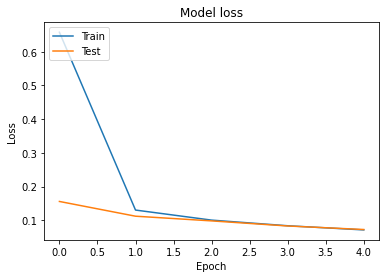

In [84]:
# Plot training & validation accuracy values
plt.plot(history.history['crf_viterbi_accuracy'])
plt.plot(history.history['val_crf_viterbi_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [111]:
# Eval
pred_cat = model.predict(X_tr)
pred = np.argmax(pred_cat, axis=-1)
y_te_true = np.argmax(y_tr, -1)

In [112]:
from sklearn_crfsuite.metrics import flat_classification_report

# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true] 

report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag)
print(report)

C:\Users\PhilipHuang\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\Users\PhilipHuang\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           -       0.00      0.00      0.00         1
       B-Act       0.86      0.09      0.16        67
     B-Light       0.00      0.00      0.00        39
       B-Oth       0.86      0.86      0.86       228
       B-Tri       0.85      0.87      0.86       339
       I-Act       0.75      0.13      0.22        69
       I-Oth       0.00      0.00      0.00         4
       I-Tri       0.00      0.00      0.00         8
       L-Act       0.83      0.07      0.14        67
     L-Light       0.00      0.00      0.00        39
       L-Oth       0.86      0.87      0.86       228
       L-Tri       0.84      0.87      0.85       339
           O       0.96      0.97      0.97     21578
         PAD       1.00      1.00      1.00     96637
       U-Act       0.00      0.00      0.00        37
     U-Light       0.82      0.87      0.85       222
       U-Oth       0.90      0.11      0.20        81
       U-Tri       0.00    

In [80]:
idx2word[626]

'are'

In [113]:
X_tr[20]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,  626,  495,
       2459,  209,  179, 1895,  173, 1462,   60, 2052, 1733])

In [122]:
i = np.random.randint(0,X_tr.shape[0]) # choose a random number between 0 and len(X_te)
p = model.predict(np.array([X_tr[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_tr[i], -1)

print("Sample number {} of {} (Test Set)".format(i, X_tr.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_tr[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))

Sample number 797 of 1600 (Test Set)
Word           ||True ||Pred
the            : O     O
units          : O     O
motherboard    : U-Oth O
may            : O     O
be             : O     O
dead           : O     O
attached       : O     O
video          : O     O
recording      : O     O
for            : O     O
the            : O     O
red            : U-Light U-Light
indicator      : O     O
on             : O     O
the            : O     O
motherboard    : U-Oth U-Oth
turns          : O     O
green          : O     U-Light
when           : O     O
the            : O     O
switch         : O     O
is             : O     O
turned         : O     O
on             : O     O
but            : O     O
then           : O     O
turns          : O     O
red            : U-Light U-Light
after          : O     O
a              : O     O
few            : O     O
seconds        : O     O
unit           : O     O
fails          : O     O
to             : O     O
turn           : O     B-Tri
on  

In [120]:
data.iloc[i]

Sentence    Can you send us a replacement
label                  [O, O, O, O, O, O]
Name: 1581, dtype: object

In [88]:
type(words[w-2])

spacy.tokens.token.Token

In [119]:
len(X_te)

14

In [93]:
data['Sentence'][11]

'After a power outage the unit fails to turn on.We have checked the power from the power supply with a multi - meter and it is putting out 12 volts as specified.There are no powere lights showing on the device itself which to me indicates that the motherboard is at fault.I dont believe the unit is fused protected. We require assistance on repairing or replacing the motherboard or any other fault finding tasks.'